# Deep Neural Network: Anti-Microbial Peptide Prediction

## TensorFlow Model

In [135]:
# Import Dependencies.
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

# Set Font for Matplotlib
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica Neue Light', 'Helvetica Neue', 'Arial']

# Set DPI of all Plots
plt.rcParams["figure.dpi"] = 150

# Set Dark Grid for all Plots
sns.set_style('darkgrid')

# Import Data
validation_df = pd.read_csv("Resources/validation.csv")
validation_positive_df = pd.read_csv("Resources/validation_positive.csv")
validation_negative_df = pd.read_csv("Resources/validation_negative.csv")

In [136]:
# One-Hot Encode Amino Acid Sequences

# FUNCTION: One-Hot Encode Amino Acid Sequence
def one_hot_encode(sequence):
    # Amino Acids
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
    # Map unique Amino Acids to Column indices
    amino_acid_to_index = {aa: i for i, aa in enumerate(amino_acids)}
    one_hot_matrix = np.zeros((len(sequence), len(amino_acids)), dtype=int)
    for i, aa in enumerate(sequence):
        if aa in amino_acid_to_index:
            one_hot_matrix[i, amino_acid_to_index[aa]] = 1
    return one_hot_matrix

In [137]:
# Pad One-Hot Encoded Amino Acid Sequences (make each sequence the same size for CNN Model)

# FUNCTION: Pads One-Hot-Encoded Array Sequences
def pad_arrays(arr_list, desired_len):
    while len(arr_list) < desired_len:
        arr_list = np.vstack((arr_list, np.zeros(arr_list[0].shape, dtype=np.int64)))
    return arr_list

### Preprocess Data

In [138]:
# One-Hot Encode Sequence Column
validation_df['One_Hot_Encoded'] = validation_df['Sequence'].apply(one_hot_encode)
validation_positive_df['One_Hot_Encoded'] = validation_positive_df['Sequence'].apply(one_hot_encode)
validation_negative_df['One_Hot_Encoded'] = validation_negative_df['Sequence'].apply(one_hot_encode)

In [139]:
# Find Max Amino Acid Sequence Length
max_length = 198

# Apply the padding function to the 'One_Hot_Encoded' column
validation_df['Padded_One_Hot'] = validation_df['One_Hot_Encoded'].apply(lambda arr_list: pad_arrays(arr_list, max_length))
validation_positive_df['Padded_One_Hot'] = validation_positive_df['One_Hot_Encoded'].apply(lambda arr_list: pad_arrays(arr_list, max_length))
validation_negative_df['Padded_One_Hot'] = validation_negative_df['One_Hot_Encoded'].apply(lambda arr_list: pad_arrays(arr_list, max_length))

In [140]:
# Check validation_df
validation_df

,Sequence_ID,Sequence,Anti_Microbial,Sequence_Length,One_Hot_Encoded,Padded_One_Hot
0,teAMP0149,GIGGALLSVGKSALKGLTKGLAEHF,1,25,"[[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,teNEGATIVE0013,GKITFYEDRNFQGRCYECSTDCPDLSPYFS,0,30,"[[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,teAMP0057,ILGPVLGLVGSVLGGLLKNL,1,20,"[[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,..."
3,teAMP0516,FKAPYNIHWHCKPGLLC,1,17,"[[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,teNEGATIVE0111,VVGGEVARAHSWPWQISLQY,0,20,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...,...,...,...,...
1665,teNEGATIVE0366,GAYGQGQNIGQLFVNILIFLFY,0,22,"[[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1666,teNEGATIVE0205,RPEEIGAGDQGHMFG,0,15,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,..."
1667,teAMP0520,ILGPILGLVSNALGGLLG,1,18,"[[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,..."
1668,teAMP0622,YSWPRMPRIPRLPRYPRYPRYPRWPRWPRQPTIYA,1,35,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [141]:
# Check peptides_df
validation_positive_df

,Sequence_ID,Sequence,Anti_Microbial,Sequence_Length,One_Hot_Encoded,Padded_One_Hot
0,teAMP0001,QLPICGETCVLGGCYTPNCRCQYPICVR,1,28,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,..."
1,teAMP0002,MSGRGKGGKGLGKGGAKRHRKVLRDNIQGITKPAIRRLARRGGVKR...,1,103,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,..."
2,teAMP0003,GLWSTIKNVGKEAAIAAGKAVLGSL,1,25,"[[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,teAMP0004,APFCIGYLSPKLKDMEPKPRG,1,21,"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,teAMP0005,SLRGCWTKSFPPQPCLGKR,1,19,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...,...,...,...,...
830,teAMP0831,ALLDKLKSLGKVVGKVALGVVQNYLNPRQ,1,29,"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
831,teAMP0832,KKCGFFCKLKNKLKSTGSRSNIAAGTHGGTFRV,1,33,"[[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,..."
832,teAMP0833,DIGTKILGGVKTALKGALKELASTYVN,1,27,"[[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
833,teAMP0834,KSGGGGWGSGGGGGGGGGWWWSGWGVDR,1,28,"[[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,..."


In [142]:
# Check validation_negative_df
validation_negative_df

,Sequence_ID,Sequence,Anti_Microbial,Sequence_Length,One_Hot_Encoded,Padded_One_Hot
0,teNEGATIVE0001,ADDKCEDSLRREIACTKCRDRVRTDDYFYECCTSESTFKKCQTMLHQ,0,47,"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,teNEGATIVE0002,MDIITLGWVGVLSVFTLSIAFVVWGRHGM,0,29,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,..."
2,teNEGATIVE0003,IVGGVEAVPGVWPYQAALFIIDMYFCGGSLI,0,31,"[[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,..."
3,teNEGATIVE0004,AVKCIGWQETCNGKLPCCDGCVMCECNIMGQNCRCNHPKATSECES,0,46,"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,teNEGATIVE0005,MSDINATRLPIWGIGCDPCIGDDVTILLTRGE,0,32,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,..."
...,...,...,...,...,...,...
830,teNEGATIVE0831,MSQSLFNLKSLSRSINNTIRMRRYIVITKASQRAYTIGSSQEKPSW...,0,124,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,..."
831,teNEGATIVE0832,AEPNVTVTGAAGQIGYALLFRI,0,22,"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
832,teNEGATIVE0833,IVGGNEVTPHAYPWQVGLFIDDMYFCGGSISVTLTGWGKP,0,40,"[[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,..."
833,teNEGATIVE0834,MFFKWISKFIRRLSKCGIKSITSKAYK,0,27,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,..."


In [143]:
# Create Variables for Sequence ID
validation_sequence_ID = validation_df['Sequence_ID']
validation_positive_sequence_ID = validation_positive_df['Sequence_ID']
validation_negative_sequence_ID = validation_negative_df['Sequence_ID']

In [144]:
# Take Values for TensorFlow CNN Model
validation_sequences = validation_df['Padded_One_Hot'].values
validation_positive_sequences = validation_positive_df['Padded_One_Hot'].values
validation_negative_sequences = validation_negative_df['Padded_One_Hot'].values

In [145]:
# Convert Input Data to Numpy Array
validation_sequences = np.array([np.array(val) for val in validation_sequences])
validation_positive_sequences = np.array([np.array(val) for val in validation_positive_sequences])
validation_negative_sequences = np.array([np.array(val) for val in validation_negative_sequences])


### Validate Model using Independent Dataset

In [146]:
# Load Trained Model
model = tf.keras.models.load_model('HDF5_files/convolutional_nn_1.h5')

In [147]:
# Make Predictions
validation_predictions = model.predict(validation_sequences)
positive_predictions = model.predict(validation_positive_sequences)
negative_predictions = model.predict(validation_negative_sequences)

27/27 [==============================] - 0s 3ms/step


In [148]:
# Create DataFrames containing Prediction Results for Confusion Matrix or Plotting
combined_df = pd.DataFrame({'Sequence ID': validation_sequence_ID, 'Score':validation_predictions.ravel().tolist(), 'Anti_Microbial': validation_df['Anti_Microbial']})
positive_df = pd.DataFrame({'Sequence ID': validation_positive_sequence_ID, 'Positive Score':positive_predictions.ravel().tolist()})
negative_df = pd.DataFrame({'Sequence_ID': validation_negative_sequence_ID, 'Negative Score': negative_predictions.ravel().tolist()})

In [149]:
# Convert Score to Binary Values for Confusion Matrix
combined_df['Predicted'] = np.where(combined_df['Score'] < 0.5, 0, 1)
combined_df

,Sequence ID,Score,Anti_Microbial,Predicted
0,teAMP0149,0.998588,1,1
1,teNEGATIVE0013,0.113722,0,0
2,teAMP0057,0.998465,1,1
3,teAMP0516,0.852351,1,1
4,teNEGATIVE0111,0.025296,0,0
...,...,...,...,...
1665,teNEGATIVE0366,0.061645,0,0
1666,teNEGATIVE0205,0.022368,0,0
1667,teAMP0520,0.998045,1,1
1668,teAMP0622,0.182311,1,0


In [150]:
# Generate Confusion Matrix
confusion_matrix = confusion_matrix(combined_df['Anti_Microbial'], combined_df['Predicted'])

In [151]:
# Create DataFrame of Confusion Matrix
confusion_matrix_df = pd.DataFrame(confusion_matrix,
                                   index= ["AMP", "Non-AMP"],
                                   columns = ["Predicted AMP", "Predicted Non-AMP"])
confusion_matrix_df

,Predicted AMP,Predicted Non-AMP
AMP,739,96
Non-AMP,154,681


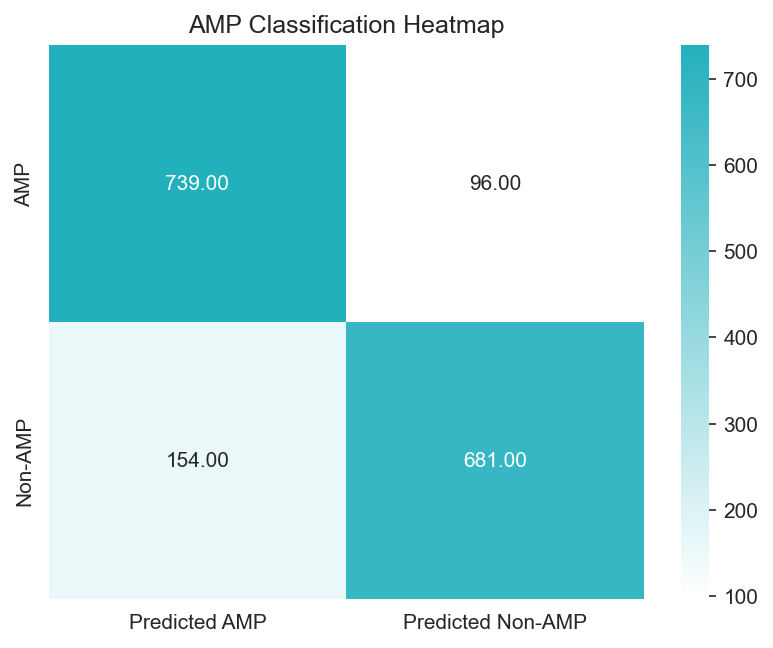

In [152]:
# Display confusion_matrix_df as Heatmap

# Set Color palette
color = ['#f8cd82', '#f65b74', '#f72078', '#23b0bd', '#0df7db']

# Create Custom Color Map
custom_cmap = mcolors.LinearSegmentedColormap.from_list("Color_Map", ['white', color[3]], N=256)

# Generate Heatmap
sns.heatmap(confusion_matrix_df, cmap=custom_cmap, annot=True, fmt=".2f")
plt.title("AMP Classification Heatmap")
plt.show()

In [153]:
# Create Classification Report of ConvNet Model

# Define target names
target_names = ['AMP', 'Non-AMP']

# Generate Classification Report
class_report = classification_report(combined_df['Anti_Microbial'], combined_df['Predicted'], target_names=target_names)

print(class_report)

              precision    recall  f1-score   support

         AMP       0.83      0.89      0.86       835
     Non-AMP       0.88      0.82      0.84       835

    accuracy                           0.85      1670
   macro avg       0.85      0.85      0.85      1670
weighted avg       0.85      0.85      0.85      1670



### Visualise Discrete Dataset

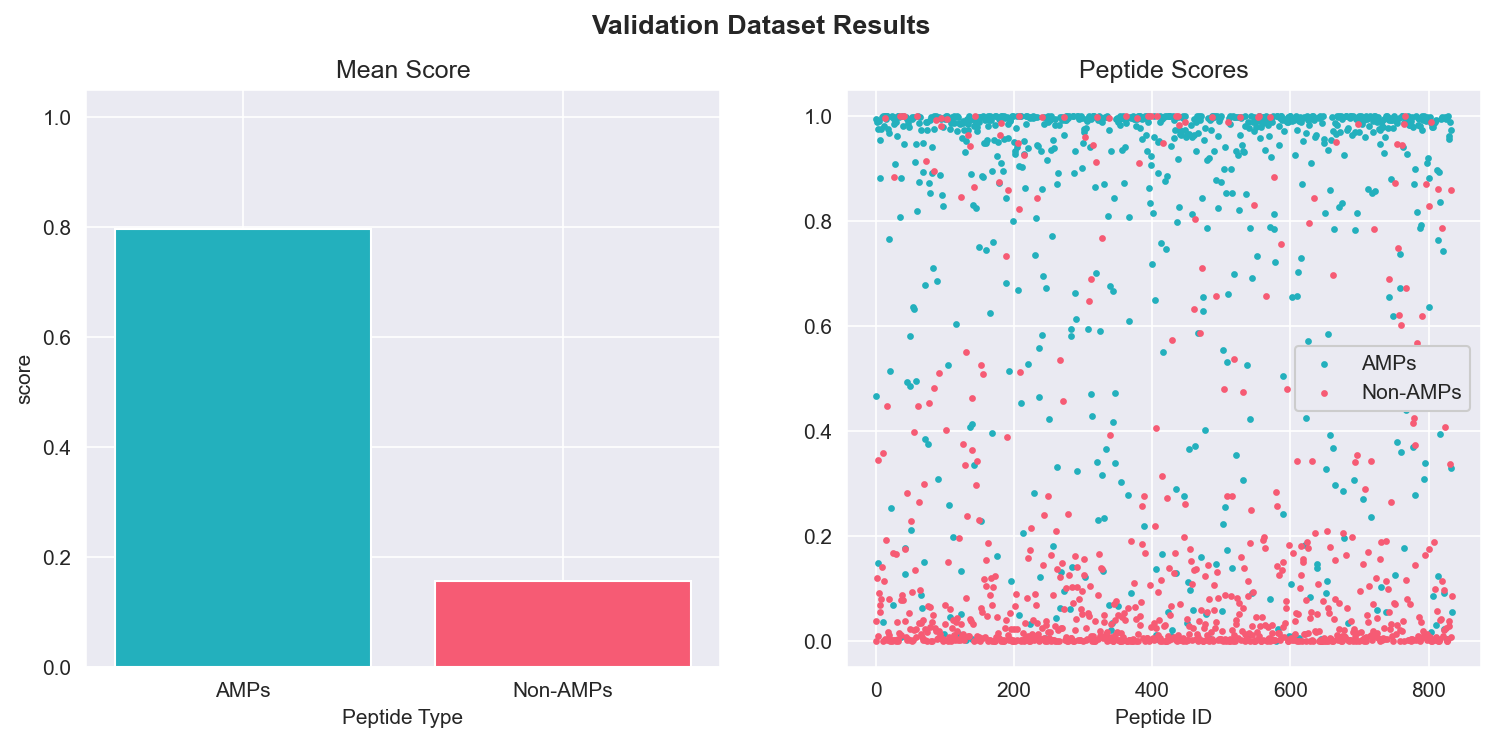

In [154]:
# Plot Anti-Microbial Prediction Scores for Discrete Validation Dataset
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Set Color palette
color = ['#f8cd82', '#f65b74', '#f72078', '#23b0bd', '#0df7db']

# Bar Chart Variables
x_bar = ['AMPs', 'Non-AMPs']
y_bar = [positive_predictions.mean(), negative_predictions.mean()]

# Plot Bar Chart
ax[0].bar(x_bar, y_bar, color=[color[3], color[1]])
ax[0].set_xlabel('Peptide Type')
ax[0].set_title('Mean Score')
ax[0].set_ylabel('score')
ax[0].set_ylim(0, 1.05)

# Scatter Plot Variables
x = positive_df.index
y1 = positive_df['Positive Score']
y2 = negative_df['Negative Score']

# Plot Scatter Plot
ax[1].scatter(x, y1, label='AMPs', color=color[3], s=5)
ax[1].scatter(x, y2, label='Non-AMPs', color=color[1], s=5)
ax[1].set_xlabel('Peptide ID')
ax[1].legend(loc='center right', framealpha=1)
ax[1].set_title('Peptide Scores')

# Set Main Title (super title)
plt.suptitle("Validation Dataset Results", fontsize=13, fontweight='bold')

# Show Figure
plt.show()

In [156]:
# Calculate Accuracy for Discrete AMP Predictions
high_score = positive_df['Positive Score'] > 0.5
high_score_accuracy = round((high_score.value_counts()[0]/(high_score.value_counts()[0]+high_score.value_counts()[1]))*100, 1)

# Calculate Accuracy for Non-AMP Predictions
low_score = negative_df['Negative Score'] < 0.5
low_score_accuracy = round((low_score.value_counts()[0]/(low_score.value_counts()[0]+low_score.value_counts()[1]))*100, 1)

print(f'Accuracy: AMPs = {high_score_accuracy} % \\\ Non-AMPs = {low_score_accuracy} %')

Accuracy: AMPs = 81.6 % \\ Non-AMPs = 88.5 %
